In [1]:
import os
import sys
import time
import math

import dill
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from src import utils
from src import bilstm
import src.dataset as dset
import src.pytorch_utils as ptu
import src.chu_liu_edmonds as chu

import warnings
warnings.filterwarnings('ignore')

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)

device = torch.device("cpu")
print(device)
versions_dir = 'models'

cpu


In [2]:
train_dataset = dset.DataSet('data/train.labeled', tqdm_bar=True, use_glove=True)
test_dataset = dset.DataSet('data/test.labeled', train_dataset=train_dataset, tqdm_bar=True, use_glove=True)
comp_dataset = dset.DataSet('data/comp.unlabeled', train_dataset=train_dataset, tagged=False, tqdm_bar=True, use_glove=True)

100%|██████████| 24744/24744 [00:03<00:00, 7587.88it/s]


In [3]:
version = 'V2_1.9'

In [4]:
checkpoint = ptu.load_model(version=version, versions_dir=versions_dir, epoch='best', seed=42)
display(checkpoint.model)
display(checkpoint.log)

model version: V2_1.9
Number of parameters 8155736 trainable 3905936
epochs: 42
train_time: 52.718

last train_loss: 0.00139
last val_loss: 0.76886
last train_score: 0.99939
last val_score: 0.91515
best val_score: 0.91515 at epoch 42


BiLSTM(
  (word_embedding_layer): Embedding(14166, 300)
  (tag_embedding_layer): Embedding(48, 32, padding_idx=0)
  (lstm): LSTM(332, 200, num_layers=4, batch_first=True, dropout=0.4, bidirectional=True)
  (attention): MultiplicativeAttention(
    (W): Linear(in_features=400, out_features=400, bias=True)
  )
  (softmax): LogSoftmax()
)

,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,amsgrad,betas,eps,lr,weight_decay
1,1.019606,19:07:06 27-06-2020,0.446346,0.481476,0.867450,0.859363,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
2,2.303434,19:08:23 27-06-2020,0.331724,0.413096,0.895848,0.873710,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
3,3.550601,19:09:38 27-06-2020,0.258116,0.383552,0.916698,0.883659,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
4,4.825338,19:10:54 27-06-2020,0.208926,0.372919,0.932268,0.889332,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
5,6.108461,19:12:11 27-06-2020,0.160918,0.366856,0.947181,0.895786,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
6,7.621381,19:13:42 27-06-2020,0.137997,0.381521,0.954530,0.898253,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
7,8.886682,19:14:58 27-06-2020,0.114987,0.396972,0.961446,0.896444,8,False,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
8,9.989910,19:16:04 27-06-2020,0.098994,0.412864,0.966171,0.896567,8,False,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
9,11.077119,19:17:09 27-06-2020,0.080169,0.414591,0.973620,0.900062,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
10,12.492016,19:18:34 27-06-2020,0.074387,0.419388,0.974475,0.901501,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07


In [7]:
# checkpoint.save(best=True)

In [8]:
%%time
test_loss, test_score, test_y_pred, test_y_true = checkpoint.predict(test_dataset.dataset(train=False),
                                                                     batch_size=32,
                                                                     device=device,
                                                                     results=True,
                                                                     decision_func=chu.test_chu_liu_edmonds)
print(f'chu_liu_edmonds_UAS: {test_score}')

chu_liu_edmonds_UAS: 0.9151490236382323
CPU times: user 38.4 s, sys: 2.23 s, total: 40.6 s
Wall time: 8.19 s


In [9]:
test_dataset.insert_predictions(preds=test_y_pred, name='test_m2')

In [10]:
%%time
comp_loss, comp_score, comp_y_pred, comp_y_true = checkpoint.predict(comp_dataset.dataset(train=False),
                                                                     batch_size=32,
                                                                     device=device,
                                                                     results=True,
                                                                     decision_func=chu.test_chu_liu_edmonds)
print(f'chu_liu_edmonds_UAS: {comp_score}')

chu_liu_edmonds_UAS: 0.04274764150943396
CPU times: user 44.8 s, sys: 3.15 s, total: 47.9 s
Wall time: 12 s


In [11]:
comp_dataset.insert_predictions(preds=comp_y_pred, name='comp_m2')

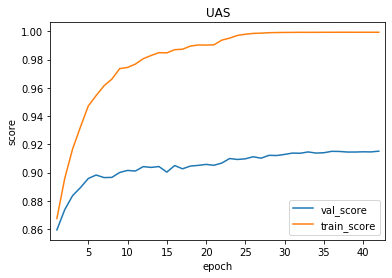

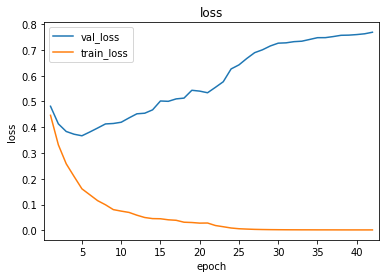

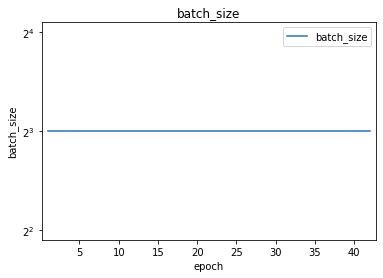

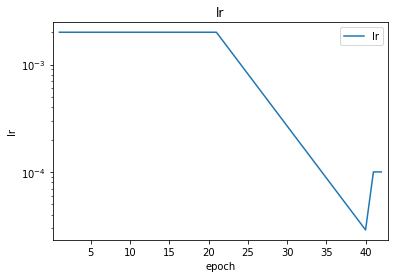

In [10]:
plt_save = True
checkpoint.plot_checkpoint(['val_score', 'train_score'], plot_title='UAS', y_label='score', scale='linear', basey=10, save=plt_save)
checkpoint.plot_checkpoint(['val_loss', 'train_loss'], plot_title='loss', y_label='loss', scale='linear', basey=10, save=plt_save)
checkpoint.plot_checkpoint(['batch_size'], plot_title='batch_size', y_label='batch_size', scale='log', basey=2, save=plt_save)
checkpoint.plot_checkpoint(['lr'], plot_title='lr', y_label='lr', scale='log', basey=10, save=plt_save)

In [11]:
checkpoint.log.tail(1)

,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,amsgrad,betas,eps,lr,weight_decay
42,52.717538,20:17:17 27-06-2020,0.001393,0.768856,0.999394,0.915149,8,True,False,"(0.9, 0.999)",1.000000e-08,0.0001,0.0


In [12]:
torch.save(checkpoint.model, 'model_m2_final.pth')